Solve for homogeneous Poisson problems using FEANet framework 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import h5py
import meshio
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.model import KNet, FNet
from FEANet.jacobi import JacobiBlockPBC
from Utils import plot

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, n, f = None, size=2.0):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.InstantiateFEANet()
        self.jac = JacobiBlockPBC(self.grid, self.Knet, self.omega)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)

        if(f is None):
            f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = self.fnet(self.jac.pbc_boundary(f)) # due to padding = 1, the output size is n+3 rather than n+1

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, initial_v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = initial_v
        for i in range(num_sweeps_down):
            v = self.jac.jacobi_convolution(v, f)
        return v


In [3]:
import Data.IsoPoisson.gaussian_random_fields as gr

def GaussianRF(n):
    alpha = random.uniform(2.0,5.0)
    rf = gr.gaussian_random_field(alpha=alpha, size=n)
    return rf.astype('float32')

In [4]:

# Problem parameters
n = 2**5

x = torch.linspace(-1,1,n+1)
y = torch.linspace(-1,1,n+1)
xx, yy = torch.meshgrid(x, y, indexing='ij')

# rhs = torch.sin(1.*torch.pi*(xx+0.5))*torch.cos(1.*torch.pi*(yy)).reshape((1,1,n+1,n+1))
rhs = torch.from_numpy(GaussianRF(n+1)).reshape((1,1,n+1,n+1))
prob = SingleGrid(n, rhs-rhs.mean())

RHS:


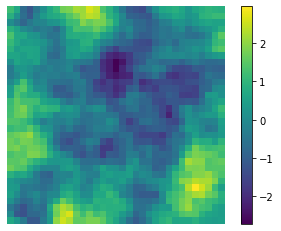

In [5]:
print("RHS:")
plot.plot_field(rhs.detach())

In [6]:
EPS = 1e-6
n_jacobi = 0
u_jacobi = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
u_jacobi_pbc = prob.jac.pbc_boundary(u_jacobi)

residual = prob.f-prob.Knet(u_jacobi_pbc)
u_jacobi = prob.jac.reset_boundary(u_jacobi)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_jacobi = [res]
print(n_jacobi, res)

while (res > EPS):
    u_jacobi = prob.Relax(u_jacobi, prob.f, 1)
    u_jacobi_pbc = prob.jac.pbc_boundary(u_jacobi)
    residual = prob.f-prob.Knet(u_jacobi_pbc)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_jacobi.append(res)
    n_jacobi += 1
    print(n_jacobi, res)

0 0.12166211009025574
1 0.1155751571059227
2 0.11108533293008804
3 0.10736445337533951
4 0.10413600504398346
5 0.10126270353794098
6 0.09866293519735336
7 0.09628276526927948
8 0.09408402442932129
9 0.0920383632183075
10 0.09012405574321747
11 0.08832395821809769
12 0.08662428706884384
13 0.08501376956701279
14 0.08348304778337479
15 0.0820242241024971
16 0.0806305855512619
17 0.07929634302854538
18 0.0780164897441864
19 0.07678662240505219
20 0.07560287415981293
21 0.07446179538965225
22 0.07336032390594482
23 0.07229568064212799
24 0.07126539200544357
25 0.0702672153711319
26 0.06929909437894821
27 0.06835916638374329
28 0.06744575500488281
29 0.06655727326869965
30 0.06569230556488037
31 0.06484954804182053
32 0.06402777880430222
33 0.0632258877158165
34 0.0624428428709507
35 0.06167769059538841
36 0.0609295479953289
37 0.06019759923219681
38 0.05948107689619064
39 0.0587792731821537
40 0.05809153988957405
41 0.05741725489497185
42 0.05675584822893143
43 0.056106794625520706
44 0.05

Solution converges after  576 Weighted Jacobi iterations
Solution:


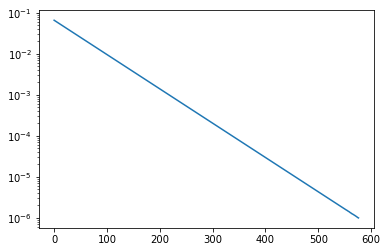

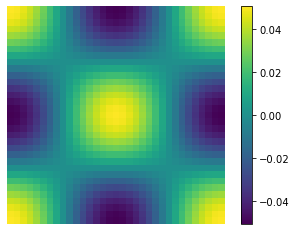

In [ ]:
print("Solution converges after ", n_jacobi, "Weighted Jacobi iterations")

plt.plot(res_jacobi)
plt.yscale('log')

print("Solution:")
plot.plot_field(u_jacobi.detach())
